In [53]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

stock_df = pd.read_csv('assignment_1b-data-1.csv')
ATBG = stock_df['ATBG']
BRDW = stock_df['BRDW']

In [113]:
# use previous  days data for training
window_size = 5
X_ATBG = np.array([ATBG[i:i+window_size] for i in range(len(ATBG)-window_size)] )
Y_ATBG = np.array( ATBG[window_size:] ).reshape(-1,1)
X_BRDW = np.array([BRDW[i:i+window_size] for i in range(len(BRDW)-window_size)] )
Y_BRDW = np.array( BRDW[window_size:] ).reshape(-1,1)

# standardscaler for data
scaler = MinMaxScaler()
X_ATBG = scaler.fit_transform(X_ATBG)
Y_ATBG = scaler.fit_transform(Y_ATBG)
X_BRDW = scaler.fit_transform(X_BRDW)
Y_BRDW = scaler.fit_transform(Y_BRDW)
# transform data format to torch tensor 
X_ATBG_tensor = torch.tensor(X_ATBG, dtype=torch.float32)
Y_ATBG_tensor = torch.tensor(Y_ATBG, dtype=torch.float32).squeeze(1)
X_BRDW_tensor = torch.tensor(X_BRDW, dtype=torch.float32)
Y_BRDW_tensor = torch.tensor(Y_BRDW, dtype=torch.float32).squeeze(1)
print(X_ATBG_tensor.shape)

torch.Size([95, 5])


In [61]:
"""   model selection problem 

    def __init__(self, input_size):
        super(StockPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32,1)
        self.relu = nn.ReLU()

    def forward(self, x):
        outl1 = self.relu(self.fc1(x))
        outl2 = self.relu(self.fc2(outl1))
        outputs = self.fc3(outl2)
        return outputs
    
    """

'   model selection problem \n\n    def __init__(self, input_size):\n        super(StockPredictor, self).__init__()\n        self.fc1 = nn.Linear(input_size, 64)\n        self.fc2 = nn.Linear(64, 32)\n        self.fc3 = nn.Linear(32,1)\n        self.relu = nn.ReLU()\n\n    def forward(self, x):\n        outl1 = self.relu(self.fc1(x))\n        outl2 = self.relu(self.fc2(outl1))\n        outputs = self.fc3(outl2)\n        return outputs\n    \n    '

In [190]:
# 定义神经网络模型
class StockPredictor(nn.Module):
    
    def __init__(self, input_size):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, 32, batch_first=True)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc1(out)  
        out = self.fc2(out)
        return out
    

def lstm(x_train, y_train, window_size=5, lr=0.05, epochs = 1500):
    input_size = window_size
    model = StockPredictor(input_size)
    criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(), lr)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(torch.unsqueeze(x_train, dim=0))
        loss = criterion(outputs.view(-1), y_train)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 300 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    return outputs, model



In [ ]:
output_ATBG, ATBGmodel = lstm(X_ATBG_tensor,Y_ATBG_tensor, 5, 0.03, 1500)


In [191]:
output_BRDW, BRDWmodel = lstm(X_BRDW_tensor,Y_BRDW_tensor, 5, 0.05,2500)

Epoch [300/2500], Loss: 0.0033
Epoch [600/2500], Loss: 0.0022
Epoch [900/2500], Loss: 0.0032
Epoch [1200/2500], Loss: 0.0016
Epoch [1500/2500], Loss: 0.0004
Epoch [1800/2500], Loss: 0.0000
Epoch [2100/2500], Loss: 0.0000
Epoch [2400/2500], Loss: 0.0000


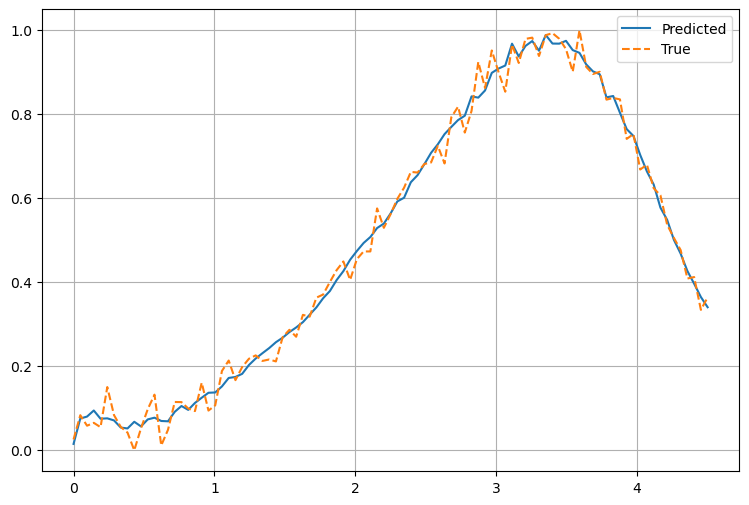

In [171]:
# ATBG fitting with trained model
ATBG_pred_bf = ATBGmodel(torch.unsqueeze(X_ATBG_tensor, dim=0)).detach().numpy()
plt.figure(figsize=(9,6))
plt.plot(np.linspace(0,4.5,95),ATBG_pred_bf.reshape(95,1), label="Predicted")
plt.plot(np.linspace(0,4.5,95),Y_ATBG_tensor, label="True", linestyle='--')
plt.legend()
plt.grid()
plt.show()

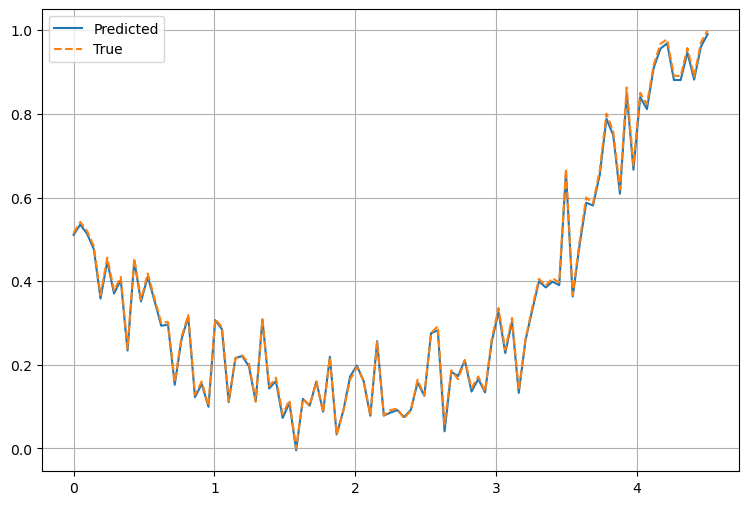

In [192]:
# BRDW fitting with trained model
BRDW_pred_df = BRDWmodel(torch.unsqueeze(X_BRDW_tensor, dim=0)).detach().numpy()
plt.figure(figsize=(9,6))
plt.plot(np.linspace(0,4.5,95),BRDW_pred_df.reshape(95,1), label="Predicted")
plt.plot(np.linspace(0,4.5,95),Y_BRDW_tensor, label="True", linestyle='--')
plt.legend()
plt.grid()
plt.show()

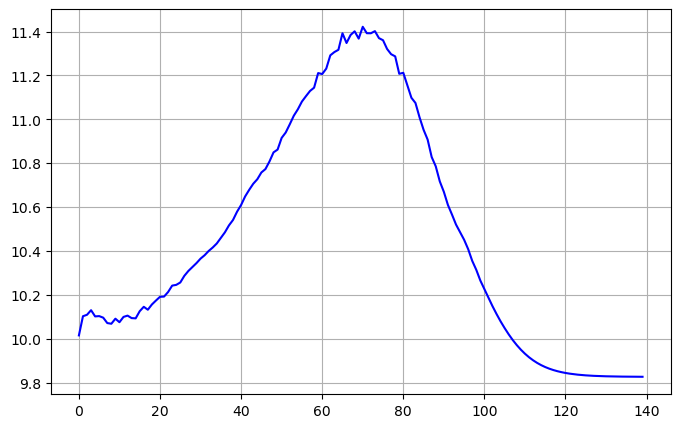

In [178]:
## ATBG prediction 4.5 months 

current_input = torch.tensor(X_ATBG[-1:], dtype=torch.float32)
current_input = current_input.unsqueeze( 0)
future_predictions = []

# iterative prediction
for _ in range(45):
    with torch.no_grad():
        prediction = model(current_input).squeeze().item()

    future_predictions.append(prediction)
    prediction = torch.tensor([[[prediction]]], dtype=torch.float32)
    current_input = torch.cat((current_input[:,:,1:],prediction ) , dim =2 )


# plot total prediction for ATBG return data

return_future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))
return_future_predictions = return_future_predictions
total = np.vstack((scaler.inverse_transform(ATBG_pred_bf.reshape(95,1)).reshape(95,1)  ,return_future_predictions) )

plt.figure(figsize = (8,5))
plt.plot(total[:], color='blue', label='total prediction for 9 months')    
plt.grid()

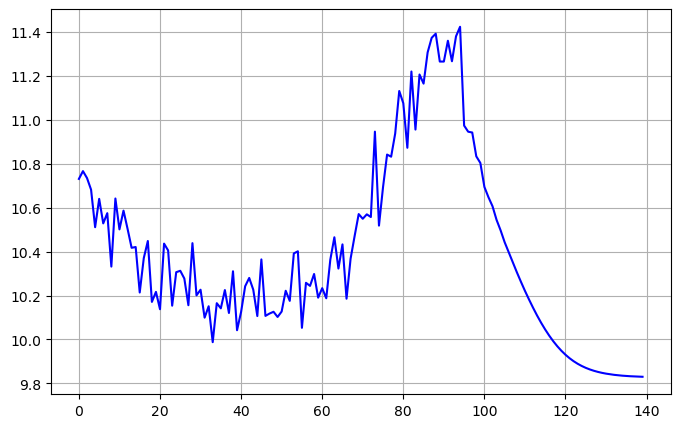

In [193]:
## BRDW prediction 4.5 months 

current_input = torch.tensor(X_BRDW[-1:], dtype=torch.float32)
current_input = current_input.unsqueeze( 0)
future_predictions = []

# iterative prediction
for _ in range(45):
    with torch.no_grad():
        prediction = model(current_input).squeeze().item()

    future_predictions.append(prediction)
    prediction = torch.tensor([[[prediction]]], dtype=torch.float32)
    current_input = torch.cat((current_input[:,:,1:],prediction ) , dim =2 )


# plot total prediction for ATBG return data

return_future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))
return_future_predictions = return_future_predictions
total = np.vstack((scaler.inverse_transform(BRDW_pred_df.reshape(95,1)).reshape(95,1)  ,return_future_predictions) )

plt.figure(figsize = (8,5))
plt.plot(total[:], color='blue', label='total prediction for 9 months')    
plt.grid()